Objective:
My objevtive for the machine learning project is to create a Recurrent Neural Network (RNN) that can generate (somewhat) legible poetry based on a collection of poems with a GAN external network to optimize the RNN potential. To do so, I will take a kaggle dataset with 500+ poems written from the reniassance and modern era of poetry to be used as the 'real' data for the discriminator.

Tools:
Libraries include pandas, numpy, keras.preprocessing for tokenizer (discussed below), GloVe dictionary (below), and keras.layers/models and the like for neural network model architecture and execution. 

Various hygiene methods are required to standardize each poem into the same length, as well as adding padding for poems less in length. Instead of feeding in actual words, I will encode each word into a tokenizer, so integers are fed into the network rather than words. Further, to better contend with writing legible poetry, I use feature engineering from https://nlp.stanford.edu/projects/glove/ to encode words to higher dimensional space. Words with similar meaning should have a similar vector space, for example. 

Both the generator and discriminator have RNN structures, including one LSTM layer to predict the next word based on the series of words prior in sequence. The discriminator will take samples from our real poems and full generated poems to try and classify real from fake. 


link to data : https://www.kaggle.com/ishnoor/poetry-analysis-with-machine-learning

References: some hygiene steps came from https://www.kaggle.com/hsankesara/mr-poet and some GAN framework coding came from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb

In [2]:
import pandas as pd
import numpy as np

poems = pd.read_csv("all.csv")

#### Adding character length column

In [3]:
poems['length'] = 0
for i in range(len(poems)):
    poems['length'][i] = len(poems['content'][i])

/Users/samburtch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Clean data by deleting null entries and non-poems

In [4]:
poems = poems.sort_values(by='length') #Sort by length of poem
poems = poems[14:len(poems)-5] # Delete tails on both sides
poems = poems[poems['content'].str.contains('Published')==False]# Eliminate non-poems with 'Published'
print(len(poems))
poems = poems[poems['content'].str.contains('from Selected Poems')==False]# Eliminate non-poems with 'from Selected Poems'
print(len(poems))
poems = poems[poems['content'].str.contains('Collected Poems')==False]# Eliminate non-poems with 'from Collected Poems'
print(len(poems))
#Eliminate where poem is just intro
for ind, row in poems.iterrows():
    if row['author'] in row['content'].upper() or str(row['poem name']) in row['content'][:40]:
        poems = poems.drop([ind])
print(len(poems))

552
536
518
465


### Hygiene: only poems between 100 & 1000 in character length

In [5]:
num_poems = len(poems)
poem = poems['content'][:num_poems]
poem = poem[poems['length'] > 100]
poem = poem[poems['length'] < 1000]
poem = poem.reset_index(drop=True)
X = poem
num_poems = len(poem)

### Create vocab size and word dictionary

In [6]:
temp = ''
for i in range(num_poems):
    temp += poem[i] + ' '
poem = temp

import re
#poem = re.sub(' +',' ',poem)
poem = poem.lower()
poem = re.findall(r'[\w]+|[\'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]',poem)
words = list(set(poem))
vocab_size = len(words)
#print(vocab_size)


In [7]:
print(X.describe())

count                                                   349
unique                                                  311
top       When I was fair and young, then favor graced m...
freq                                                      3
Name: content, dtype: object


In [8]:
X[0]

'The fog comes\r\non little cat feet.\r\n\r\nIt sits looking\r\nover harbor and city\r\non silent haunches\r\nand then moves on.'

In [9]:
for i in range(len(X)):
    X[i] = X[i].replace("\r\n"," ")  

### Feature Engineering: Convert words to integers (tokenizer)  

In [10]:
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/samburtch/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
tokenizer = Tokenizer( num_words=vocab_size)

In [12]:
tokenizer.fit_on_texts(X)

In [13]:
text = tokenizer.texts_to_sequences(X)
maxlen = 0
for i in text:
    if len(i) > maxlen:
        maxlen = len(i)
text = pad_sequences(text, maxlen=maxlen, padding='post')

In [14]:
word_dict = tokenizer.word_index

In [15]:
maxwords = len(word_dict)

### Map words to 50-dim vector (embedding_matrix)

In [16]:
embedding_matrix = np.zeros((maxwords+1,50))

In [17]:
with open('glove.6B.50d.txt') as f:
    for line in f:
        l = line.split()
        if l[0] in word_dict:
            indx = word_dict[l[0]]
            for i in range(50):
                embedding_matrix[indx][i] = l[i+1]

### Create 349 x 177 x 50 X_train matrix

In [18]:
x_train = np.zeros((349,177,50),dtype='float32')
for indp, poem in enumerate(text):
    for indw, word in enumerate(poem):
        x_train[indp,indw,:] = embedding_matrix[word]

## Network 

In [19]:
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dropout, TimeDistributed, Dense, Activation, Input
from keras.optimizers import RMSprop


num_steps = 177
#hidden_size = 350
feature_dim = 50

### Generator

In [109]:
generator_input = Input(shape=(num_steps,1))

x = LSTM(feature_dim, return_sequences=True)(generator_input)
x = LSTM(feature_dim, return_sequences=True)(x)
x = LSTM(feature_dim, return_sequences=True)(x)
x = LSTM(feature_dim, return_sequences=True)(x)
x = LSTM(feature_dim, return_sequences=True)(x)

generator = Model(generator_input, x)

### Discriminator

In [141]:
discriminator_input = Input(shape=(num_steps,feature_dim))

x = LSTM(feature_dim)(discriminator_input) 
#x = LSTM(hidden_size, return_state=True)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)

discriminator_optimizer = RMSprop(lr=0.0008, clipvalue=1.0) #decay=1e-8
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

### GAN Framework

In [142]:
from keras import backend

# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = Input(shape=(num_steps,1))
gen_output = generator(gan_input)
gan_output = discriminator(gen_output)
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr=0.0004, clipvalue=1.0) #decay=1e-8
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Training Steps

In [143]:
iterations = 1000
batch_size = 5

# Start training loop
start = 0
# Track Losses
d_losses = []
g_losses = []
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size,num_steps, 1))

    # Decode them to fake poems
    generated_poems = generator.predict(random_latent_vectors)

    # Combine them with real poems
    stop = start + batch_size
    real_poems = x_train[start: stop]
    combined_poems = np.concatenate([generated_poems, real_poems])

    # Assemble labels discriminating real from fake poems
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_poems, labels)
    d_losses.append(d_loss)
    
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size**2, num_steps, 1))

    # Assemble labels that say "all real poems"
    misleading_targets = np.zeros((batch_size**2, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    g_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    g_losses.append(g_loss)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    if step % 10 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('generator loss at step %s: %s' % (step, g_loss))
        
    if g_loss > .8:
        break

/Users/samburtch/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.70852846
generator loss at step 0: 0.72943246
discriminator loss at step 10: 0.71761906
generator loss at step 10: 0.70638055
discriminator loss at step 20: 0.69417316
generator loss at step 20: 0.7626901
discriminator loss at step 30: 0.6935716
generator loss at step 30: 0.7587362
discriminator loss at step 40: 0.6922344
generator loss at step 40: 0.75392604
discriminator loss at step 50: 0.6966273
generator loss at step 50: 0.7412652
discriminator loss at step 60: 0.69162405
generator loss at step 60: 0.75158226
discriminator loss at step 70: 0.70361173
generator loss at step 70: 0.74371576
discriminator loss at step 80: 0.6976071
generator loss at step 80: 0.74270636
discriminator loss at step 90: 0.69020694
generator loss at step 90: 0.7504863
discriminator loss at step 100: 0.6965728
generator loss at step 100: 0.7373526
discriminator loss at step 110: 0.6895156
generator loss at step 110: 0.7491652
discriminator loss at step 120: 0.6934711
generato

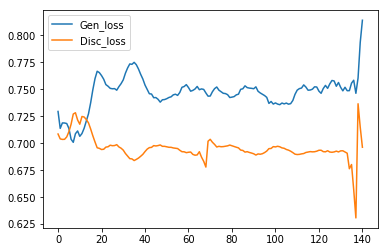

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Gen_loss','Disc_loss'])

In [147]:
random_latent_vector = np.random.normal(size=(1,num_steps, 1))

# Decode them to fake poems
generated_poem = generator.predict(random_latent_vector)

In [148]:
generated_poem.reshape(177,50)

array([[-2.26085773e-03,  1.19121664e-03,  8.51081917e-04, ...,
        -2.50620139e-03, -7.53377564e-04, -4.71913285e-04],
       [-4.16126987e-03,  1.40359974e-03,  9.19215672e-04, ...,
        -4.91611846e-03, -4.04187776e-05, -4.25234117e-04],
       [-5.79770934e-03,  8.42533831e-04,  5.22524351e-04, ...,
        -7.36912573e-03,  1.38233718e-03, -1.46849532e-04],
       ...,
       [-8.79692510e-02,  2.85432842e-02, -6.84528574e-02, ...,
        -1.10037252e-01, -1.97852105e-02,  2.48561930e-02],
       [-8.80861878e-02,  2.83576846e-02, -6.84853420e-02, ...,
        -1.10138282e-01, -1.97002850e-02,  2.45812573e-02],
       [-8.81982520e-02,  2.83221807e-02, -6.84327930e-02, ...,
        -1.10284895e-01, -1.96048226e-02,  2.43509728e-02]], dtype=float32)

In [149]:
import math
poem = []
for word in generated_poem[0]:
    num = 0
    dist = math.inf
    for ind, vec in enumerate(embedding_matrix[1:]):
        temp = np.linalg.norm(vec-word)
        if temp < dist:
            dist = temp
            num = ind
    if num != 0:
        poem.append(dist)  
    else:
        poem.append(' ')
        


The eucliean distance at each step apears to gradually increase, suggesting that the network was fairly decent at the earlier stages of the poem but got increasingly more difficult to predict the next word as the poem progressed. 

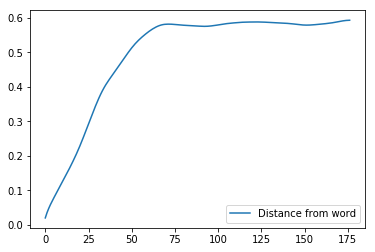

In [152]:
plt.plot(poem)
plt.legend(['Distance from word'])